<a href="https://www.kaggle.com/code/hatemalamir/entailment-bert?scriptVersionId=160960332" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
USE_TPU = False
if USE_TPU:
    !curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
    !python pytorch-xla-env-setup.py --version nightly --apt-packages libomp5 libopenblas-dev
    !pip install torch==2.1.0
    import torch_xla.core.xla_model as xm
    import torch_xla.distributed.parallel_loader as pl
    import torch_xla.distributed.xla_multiprocessing as xmp

# !pip install scipy numpy
# !pip install transformers datasets==2.15.0

import pandas as pd
import torch
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from tqdm import tqdm

# from datasets import load_dataset, Dataset, concatenate_datasets
# from transformers import AutoTokenizer, AutoModelForSequenceClassification

tqdm.pandas()

In [2]:
TRAIN_PATH = '/kaggle/input/contradictory-my-dear-watson-train-upsampled/train_upsampled.csv'
TEST_PATH = '/kaggle/input/contradictory-my-dear-watson/test.csv'
OUTPUT_PREFIX = '/kaggle/working/'
# MODEL_CKPT = 'Tverous/entailment-classification'
MODEL_CKPT = 'bert-base-uncased'
MAX_LEN=512
BATCH_SIZE = 2
EPOCHS = 2

In [3]:
train_df = pd.read_csv(TRAIN_PATH, index_col='id')

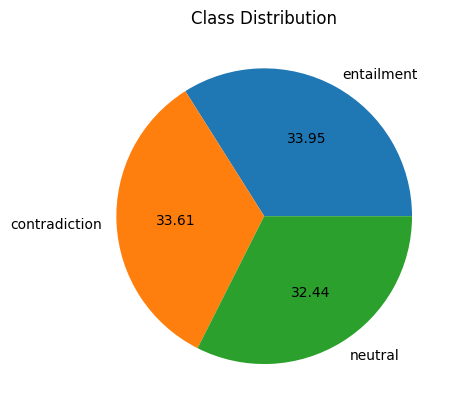

In [4]:
train_df['label'].map({0: 'entailment', 1:'neutral', 2:'contradiction'}).value_counts().plot.pie(title='Class Distribution', autopct='%.2f', ylabel='');

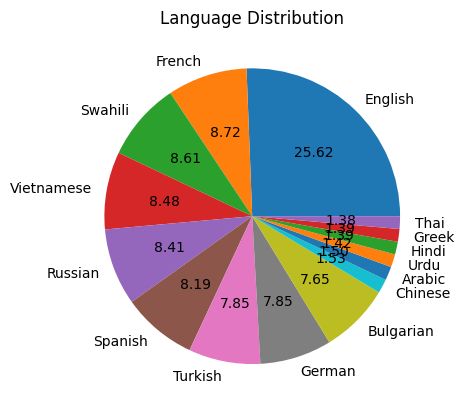

In [5]:
train_df['language'].value_counts().plot.pie(title='Language Distribution', autopct='%.2f', ylabel='');

In [6]:
clf_tokenizer = BertTokenizer.from_pretrained(MODEL_CKPT, do_lower_case=True)
print(f'>> Classifier Vocabulary Size: {clf_tokenizer.vocab_size}')
print(f'>> Classifier Model Max Length: {clf_tokenizer.model_max_length}')

def tokenize(row, tokenizer):
    premise_ids = tokenizer.encode(row['premise'], add_special_tokens=False)
    hypothesis_ids = tokenizer.encode(row['hypothesis'], add_special_tokens=False)
    token_ids = torch.tensor([tokenizer.cls_token_id] + premise_ids + [tokenizer.sep_token_id] + hypothesis_ids + [tokenizer.sep_token_id])
    
    premise_len = len(premise_ids)
    hypothesis_len = len(hypothesis_ids)
    
    attention_mask_ids = torch.tensor([1] * (premise_len + hypothesis_len + 3))
    
    segment_ids = torch.tensor([0] * (premise_len + 2) + [1] * (hypothesis_len + 1))
    
    return pd.Series({
        'token_ids': token_ids,
        'attention_mask_ids': attention_mask_ids,
        'segment_ids': segment_ids
    })
train_df = pd.concat([
    train_df,
    train_df.progress_apply(tokenize, args=(clf_tokenizer,), axis=1)
], axis=1)

token_ids = pad_sequence(train_df['token_ids'], batch_first=True)
attention_mask_ids = pad_sequence(train_df['attention_mask_ids'], batch_first=True)
segment_ids = pad_sequence(train_df['segment_ids'], batch_first=True)
labels = torch.tensor(train_df['label'])


cutoff_idx = int(train_df.shape[0] * 0.8)
train_ds = TensorDataset(
    token_ids[:cutoff_idx],
    attention_mask_ids[:cutoff_idx],
    segment_ids[:cutoff_idx],
    labels[:cutoff_idx]
)
eval_ds = TensorDataset(
    token_ids[cutoff_idx:],
    attention_mask_ids[cutoff_idx:],
    segment_ids[cutoff_idx:],
    labels[cutoff_idx:]
)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
eval_loader = DataLoader(eval_ds, batch_size=BATCH_SIZE, shuffle=False)

>> Classifier Vocabulary Size: 30522
>> Classifier Model Max Length: 512


100%|██████████| 26820/26820 [01:00<00:00, 444.04it/s]
/tmp/ipykernel_26/1777999127.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = torch.tensor(train_df['label'])


In [7]:
if USE_TPU:
    xm.master_print
    device = xm.xla_device()
else:
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'>> Acquired device: {device}')

clf_model = BertForSequenceClassification.from_pretrained(MODEL_CKPT, num_labels=3).to(device)
print(f'>> Classifier model footpring: {round(clf_model.get_memory_footprint() / (1024 * 1024), 2)} MB')

param_optimizer = list(clf_model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {
        'params':[p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
        'weight_decay_range': 0.01
    },
    {
        'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
        'weight_decay_range': 0.0
    }
]
optimizer = AdamW(optimizer_grouped_parameters, lr=5e-5, correct_bias=False)

>> Acquired device: cuda


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


>> Classifier model footpring: 417.66 MB


/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [8]:
def train_one_epoch(data_loader, model, optimizer, device):
    print('>> Training...')
    model.train(True)
    
    total_correct = 0
    total_examples = 0
    total_loss = 0

    for tok, mask, seg, lbl in data_loader:
        optimizer.zero_grad()

        tok = tok.to(device)
        mask = mask.to(device)
        seg = seg.to(device)
        lbl = lbl.to(device)
        
        loss, prediction = model(
            tok,
            attention_mask=mask,
            token_type_ids=seg,
            labels=lbl
        ).values()

        total_correct += (torch.log_softmax(prediction, dim=1).argmax(dim=1) == lbl).sum()
        total_examples += lbl.size(0)

        loss.backward()
        optimizer.step()
        if USE_TPU:
            xm.mark_step()

        total_loss += loss.item()
        
    accuracy = float(total_correct) / float(total_examples)
    avg_loss = total_loss / len(data_loader)
    
    return accuracy, avg_loss


def eval_one_epoch(data_loader, model, device):
    print('>> Evaluating...')
    model.eval()
    
    total_correct = 0
    total_examples = 0
    total_loss = 0
    
    with torch.no_grad():
        for tok, mask, seg, lbl in data_loader:
            optimizer.zero_grad()
            
            tok = tok.to(device)
            mask = mask.to(device)
            seg = seg.to(device)
            lbl = lbl.to(device)
            
            loss, prediction = model(
                tok,
                attention_mask=mask,
                token_type_ids=seg,
                labels=lbl
            ).values()
            
            total_correct += (torch.log_softmax(prediction, dim=1).argmax(dim=1) == lbl).sum()
            total_examples += lbl.size(0)
            
            total_loss += loss.item()
    
    accuracy = float(total_correct) / float(total_examples)
    avg_loss = total_loss / len(data_loader)

    return accuracy, avg_loss

for epoch in range(EPOCHS):
    print(f'\nEPOCH {epoch + 1}:')
    train_acc, train_loss = train_one_epoch(train_loader, clf_model, optimizer, device)
    print(f'>> Train Accuracy: {train_acc}, Train Avg Loss: {train_loss}')
    val_acc, val_loss = eval_one_epoch(eval_loader, clf_model, device)
    print(f'>> Validation Avg Loss: {val_acc}, Validation Accuracy: {val_loss}')


EPOCH 1:
>> Training...
>> Train Accuracy: 0.3301640566741238, Train Avg Loss: 1.1196312548052367
>> Evaluating...
>> Validation Avg Loss: 0.3484340044742729, Validation Accuracy: 1.1034146916679621

EPOCH 2:
>> Training...
>> Train Accuracy: 0.3351976137211036, Train Avg Loss: 1.1177110300857038
>> Evaluating...
>> Validation Avg Loss: 0.3346383296047726, Validation Accuracy: 1.1003213998633121


In [9]:
test_df = pd.read_csv(TEST_PATH, index_col='id')
test_df = test_df.progress_apply(tokenize, args=(clf_tokenizer,), axis=1)

test_token_ids = pad_sequence(test_df['token_ids'], batch_first=True)
test_attention_mask_ids = pad_sequence(test_df['attention_mask_ids'], batch_first=True)
test_segment_ids = pad_sequence(test_df['segment_ids'], batch_first=True)


test_ds = TensorDataset(
    test_token_ids,
    test_attention_mask_ids,
    test_segment_ids
)

test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

100%|██████████| 5195/5195 [00:11<00:00, 439.14it/s]


In [10]:
all_preds = []
print('>> Testing...')
with torch.no_grad():
    for tok, mask, seg in test_loader:
        optimizer.zero_grad()
            
        tok = tok.to(device)
        mask = mask.to(device)
        seg = seg.to(device)
            
        output = clf_model(
            tok,
            attention_mask=mask,
            token_type_ids=seg,
        ).values()
        output = list(output)[0]
        preds = torch.log_softmax(output, dim=1).argmax(dim=1)
        all_preds.extend(preds)
all_preds = [pred.item() for pred in all_preds]

>> Testing...


In [11]:
test_df['prediction'] = all_preds
test_df['prediction'].to_csv(f'{OUTPUT_PREFIX}submission.csv')